# CVEBuster Data Exploration - Sentinel Data Lake

### Overview
This notebook provides comprehensive analysis and visualization of CVEBuster vulnerability data stored in Microsoft Sentinel Data Lake.

**Key Features:**
- **Machine Risk Scoring**: Composite risk assessment based on CVSS, exploitability, and patchability
- **Trend Analysis**: Identify newly detected CVEs and vulnerability patterns
- **Quick Wins**: Prioritize high-severity patchable vulnerabilities by business owner
- **Severity Distribution**: Visualize critical findings across your infrastructure

**Data Source:** `cveBusterVulnerabilities_CL` table in Sentinel workspace

## Configuration
Set your workspace name and table details

In [ ]:
# Configuration
WORKSPACE_NAME = "sentinel-airlift-centralus"  # Your Sentinel workspace name
TABLE_NAME = "cveBusterVulnerabilities_CL"     # Your CVEBuster table name

print(f"Configured to use:")
print(f"  Workspace: {WORKSPACE_NAME}")
print(f"  Table: {TABLE_NAME}")

StatementMeta(MSGMedium, 0, 5, Finished, Available, Finished)

Configured to use:
  Workspace: sentinel-airlift-centralus
  Table: cveBusterVulnerabilities_CL


## 1. Initialize Sentinel Provider and Load Data

In [6]:
from sentinel_lake.providers import MicrosoftSentinelProvider
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

# Initialize provider
data_provider = MicrosoftSentinelProvider(spark)

# List available tables (optional sanity check)
print(f"\nTables in workspace '{WORKSPACE_NAME}':")
tables = data_provider.list_tables(WORKSPACE_NAME)
table_names = [t.name if hasattr(t, 'name') else str(t) for t in tables]
print(f"  Found {len(table_names)} tables")
if TABLE_NAME in table_names:
    print(f"  ✓ {TABLE_NAME} found!")
else:
    print(f"  ⚠ {TABLE_NAME} not found in workspace")
    print(f"  Available tables: {table_names[:10]}...")

StatementMeta(MSGMedium, 0, 7, Finished, Available, Finished)


Tables in workspace 'sentinel-airlift-centralus':
  Found 2 tables
  ✓ cveBusterVulnerabilities_CL found!


In [ ]:
# Load the vulnerability table
try:
    df = data_provider.read_table(TABLE_NAME, WORKSPACE_NAME)
    print(f"✓ Successfully loaded {TABLE_NAME}")
    print(f"  Total records: {df.count():,}")
except Exception as e:
    print(f"✗ Error loading table: {e}")
    raise

StatementMeta(MSGMedium, 0, 8, Finished, Available, Finished)

{"Level": "INFO", "TraceId": "a4dd3141-49fb-4d0e-ab17-fb6c4d29a1c9", "Message": "Loading table: cveBusterVulnerabilities_CL"}
{"Level": "INFO", "TraceId": "a4dd3141-49fb-4d0e-ab17-fb6c4d29a1c9", "Message": "Successfully loaded table cveBusterVulnerabilities_CL"}
✓ Successfully loaded cveBusterVulnerabilities_CL
  Total records: 505


In [8]:
# Display schema and sample data
print("\nTable Schema:")
df.printSchema()

print("\nSample Data (first 10 rows):")
display(df.limit(10))

StatementMeta(MSGMedium, 0, 9, Finished, Available, Finished)


Table Schema:
root
 |-- TimeGenerated: timestamp (nullable = true)
 |-- MachineName: string (nullable = true)
 |-- HostId: string (nullable = true)
 |-- IPAddress: string (nullable = true)
 |-- OSFamily: string (nullable = true)
 |-- Application: string (nullable = true)
 |-- AppFilePath: string (nullable = true)
 |-- VulnId: string (nullable = true)
 |-- VulnTitle: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- CVSS: double (nullable = true)
 |-- ExploitAvailable: boolean (nullable = true)
 |-- ExploitedInWild: boolean (nullable = true)
 |-- PatchAvailable: boolean (nullable = true)
 |-- FirstSeen: timestamp (nullable = true)
 |-- LastSeen: timestamp (nullable = true)
 |-- LastScanTime: timestamp (nullable = true)
 |-- AssetCriticality: string (nullable = true)
 |-- BusinessOwner: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- TenantId: string (nullable = true)
 |-- _ReceivedTime: timestamp (nullable = true)
 |-- _IsBillable: boolean (nulla

## 2. Data Preparation
Transform columns to proper types for analysis

In [ ]:
# Normalize columns with proper types
df_t = (
    df
    .withColumn("CvssReal", F.col("CVSS").cast("double"))
    .withColumn("ExploitAvailableBool", F.col("ExploitAvailable").cast("boolean"))
    .withColumn("ExploitedInWildBool", F.col("ExploitedInWild").cast("boolean"))
    .withColumn("PatchAvailableBool", F.col("PatchAvailable").cast("boolean"))
    .withColumn("TimeGeneratedTs", F.to_timestamp("TimeGenerated"))
    .withColumn("FirstSeenTs", F.to_timestamp("FirstSeen"))
    .withColumn("LastSeenTs", F.to_timestamp("LastSeen"))
)

# Cache for better performance
df_t.cache()

print("✓ Data prepared and cached")
print("\nPreview of normalized data:")
df_t.select(
    "MachineName", "IPAddress", "Application", "VulnId",
    "Severity", "CvssReal", "PatchAvailableBool",
    "ExploitAvailableBool", "ExploitedInWildBool", "TimeGeneratedTs"
).show(10, truncate=False)

StatementMeta(MSGMedium, 0, 10, Finished, Available, Finished)

✓ Data prepared and cached

Preview of normalized data:
+-----------+---------+-----------+---------------------+--------+--------+------------------+--------------------+-------------------+--------------------------+
|MachineName|IPAddress|Application|VulnId               |Severity|CvssReal|PatchAvailableBool|ExploitAvailableBool|ExploitedInWildBool|TimeGeneratedTs           |
+-----------+---------+-----------+---------------------+--------+--------+------------------+--------------------+-------------------+--------------------------+
|BobVM      |         |           |CVE-2024-49113       |Critical|9.8     |false             |true                |false              |2026-01-20 00:55:44.983356|
|BobVM      |         |           |CVE-2024-49112       |Critical|10.0    |false             |true                |false              |2026-01-20 00:55:44.983356|
|BobVM      |         |           |CVE-2024-48967       |High    |8.8     |true              |false               |false         

## 3. Overall Statistics
Get a high-level summary of your vulnerability landscape

In [ ]:
# Calculate overall statistics
total_vulns = df_t.count()
unique_cves = df_t.select("VulnId").distinct().count()
affected_machines = df_t.select("MachineName").distinct().count()
affected_ips = df_t.select("IPAddress").distinct().count()

# Severity breakdown
severity_counts = df_t.groupBy("Severity").count().orderBy(F.col("count").desc())

# Exploitation statistics
exploit_stats = df_t.agg(
    F.sum(F.when(F.col("ExploitAvailableBool"), 1).otherwise(0)).alias("ExploitAvailable"),
    F.sum(F.when(F.col("ExploitedInWildBool"), 1).otherwise(0)).alias("ExploitedInWild"),
    F.sum(F.when(F.col("PatchAvailableBool"), 1).otherwise(0)).alias("PatchAvailable")
).collect()[0]

print("="*60)
print("VULNERABILITY LANDSCAPE SUMMARY")
print("="*60)
print(f"Total Vulnerabilities: {total_vulns:,}")
print(f"Unique CVEs: {unique_cves:,}")
print(f"Affected Machines: {affected_machines:,}")
print(f"Affected IP Addresses: {affected_ips:,}")
print(f"\nExploitation Status:")
print(f"  Exploit Available: {exploit_stats['ExploitAvailable']:,} ({exploit_stats['ExploitAvailable']/total_vulns*100:.1f}%)")
print(f"  Exploited in Wild: {exploit_stats['ExploitedInWild']:,} ({exploit_stats['ExploitedInWild']/total_vulns*100:.1f}%)")
print(f"  Patch Available: {exploit_stats['PatchAvailable']:,} ({exploit_stats['PatchAvailable']/total_vulns*100:.1f}%)")
print(f"\nSeverity Distribution:")
severity_counts.show(truncate=False)

StatementMeta(MSGMedium, 0, 11, Finished, Available, Finished)

VULNERABILITY LANDSCAPE SUMMARY
Total Vulnerabilities: 505
Unique CVEs: 505
Affected Machines: 51
Affected IP Addresses: 1

Exploitation Status:
  Exploit Available: 267 (52.9%)
  Exploited in Wild: 121 (24.0%)
  Patch Available: 247 (48.9%)

Severity Distribution:
+--------+-----+
|Severity|count|
+--------+-----+
|Critical|136  |
|Medium  |129  |
|Low     |125  |
|High    |115  |
+--------+-----+



## 4. Machine Risk Score Analysis
Calculate composite risk scores for prioritization

In [ ]:
# Compute composite RiskScore for each machine
# Risk factors:
#   • AvgCvss (×5): emphasizes consistently severe vulnerabilities
#   • MaxCvss (×2): highlights single high-impact findings
#   • Exploitable (×3): adds weight for actively exploitable issues
#   • ExploitedInWild (×5): critical priority for active exploitation
#   • Patchable (×2): accounts for readily fixable problems
#   • VulnCount (×1): scales slightly with total vulnerability volume

machine_risk = (
    df_t.groupBy("MachineName", "IPAddress")
        .agg(
            F.avg("CvssReal").alias("AvgCvss"),
            F.max("CvssReal").alias("MaxCvss"),
            F.count("*").alias("VulnCount"),
            F.sum(F.when(F.col("ExploitAvailableBool"), 1).otherwise(0)).alias("Exploitable"),
            F.sum(F.when(F.col("ExploitedInWildBool"), 1).otherwise(0)).alias("ExploitedInWild"),
            F.sum(F.when(F.col("PatchAvailableBool"), 1).otherwise(0)).alias("Patchable"),
            F.countDistinct("VulnId").alias("UniqueCVEs")
        )
        .withColumn(
            "RiskScore",
            (
                F.col("AvgCvss") * 5 +           # average severity weight
                F.col("MaxCvss") * 2 +           # max severity weight
                F.col("Exploitable") * 3 +       # exploitability factor
                F.col("ExploitedInWild") * 5 +   # active exploitation (critical!)
                F.col("Patchable") * 2 +         # patchability factor
                F.col("VulnCount") * 1           # total vulnerability count
            )
        )
        .orderBy(F.col("RiskScore").desc())
)

print("Top 20 Machines by Risk Score:")
machine_risk.show(20, truncate=False)

StatementMeta(MSGMedium, 0, 12, Finished, Available, Finished)

Top 20 Machines by Risk Score:
+-----------+---------+------------------+-------+---------+-----------+---------------+---------+----------+------------------+
|MachineName|IPAddress|AvgCvss           |MaxCvss|VulnCount|Exploitable|ExploitedInWild|Patchable|UniqueCVEs|RiskScore         |
+-----------+---------+------------------+-------+---------+-----------+---------------+---------+----------+------------------+
|SRV-APP-038|         |7.0375            |9.9    |16       |10         |6              |7        |16        |144.9875          |
|SRV-WEB-042|         |7.070588235294117 |9.8    |17       |8          |6              |6        |17        |137.95294117647057|
|SRV-WEB-040|         |7.5               |9.6    |16       |9          |4              |9        |16        |137.7             |
|SRV-WEB-019|         |7.200000000000002 |9.9    |14       |12         |3              |5        |14        |130.8             |
|SRV-DC-048 |         |6.506666666666667 |9.8    |15       |7     

StatementMeta(MSGMedium, 0, 13, Finished, Available, Finished)

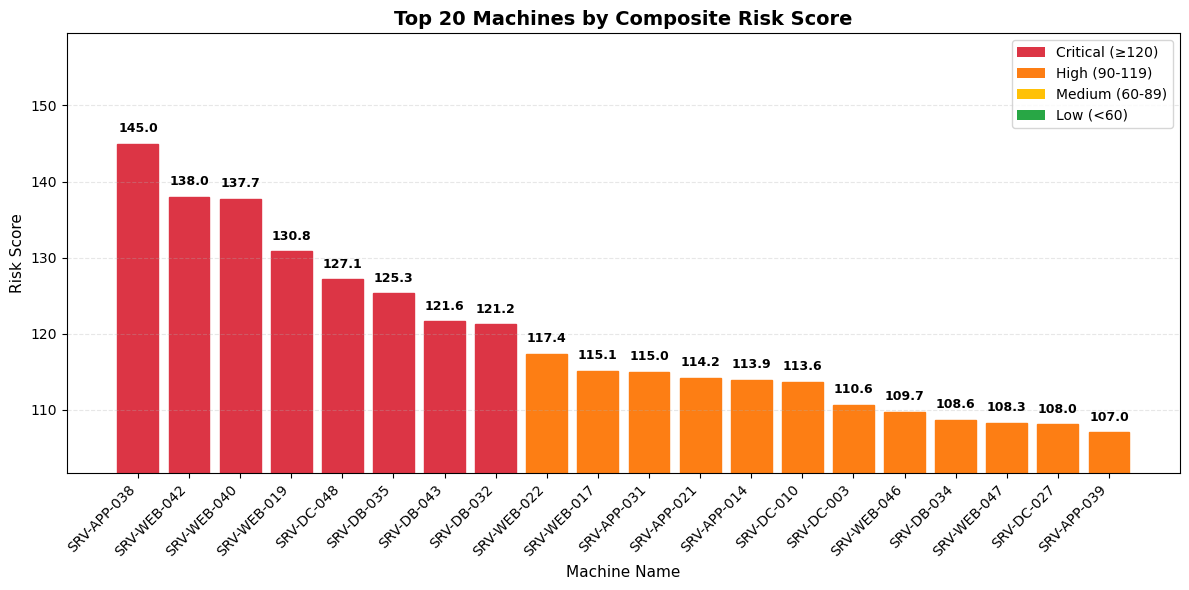

In [ ]:
# Visualize top 20 machines by RiskScore
plot_pd = machine_risk.limit(20).toPandas()

if plot_pd.empty:
    print("No data available for plotting.")
else:
    ymin = max(0, float(plot_pd["RiskScore"].min()) * 0.95)
    ymax = float(plot_pd["RiskScore"].max()) * 1.10

    plt.figure(figsize=(12, 6))
    bars = plt.bar(plot_pd["MachineName"], plot_pd["RiskScore"], edgecolor="black")

    # Color bars by threshold severity
    for i, row in enumerate(plot_pd.itertuples()):
        if row.RiskScore >= 120:
            bars[i].set_color("#dc3545")      # Critical (red)
        elif row.RiskScore >= 90:
            bars[i].set_color("#fd7e14")      # High (orange)
        elif row.RiskScore >= 60:
            bars[i].set_color("#ffc107")      # Medium (yellow)
        else:
            bars[i].set_color("#28a745")      # Low (green)

    plt.ylim(ymin, ymax)

    # Annotate bars with numeric score
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width() / 2,
            h + (ymax - ymin) * 0.02,
            f"{h:.1f}",
            ha="center",
            va="bottom",
            fontsize=9,
            weight="bold"
        )

    plt.title("Top 20 Machines by Composite Risk Score", fontsize=14, weight="bold")
    plt.xlabel("Machine Name", fontsize=11)
    plt.ylabel("Risk Score", fontsize=11)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#dc3545', label='Critical (≥120)'),
        Patch(facecolor='#fd7e14', label='High (90-119)'),
        Patch(facecolor='#ffc107', label='Medium (60-89)'),
        Patch(facecolor='#28a745', label='Low (<60)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

## 5. Recently Detected CVEs (Last 48 Hours)
Identify newly discovered vulnerabilities

In [13]:
# Filter for CVEs detected in the last 48 hours
cutoff = datetime.now(timezone.utc) - timedelta(hours=48)

new_cves = (
    df_t.filter(F.col("TimeGeneratedTs") >= F.lit(cutoff))
        .select(
            "TimeGeneratedTs", "MachineName", "IPAddress",
            "VulnId", "VulnTitle", "CvssReal", "Severity",
            "ExploitAvailableBool", "ExploitedInWildBool",
            "PatchAvailableBool", "Application", "Source"
        )
        .orderBy(F.col("TimeGeneratedTs").desc())
)

new_count = new_cves.count()
print(f"\n🆕 New CVEs Detected (Last 48 Hours): {new_count:,}")
print("="*80)

if new_count > 0:
    new_cves.show(25, truncate=False)
    
    # Summary statistics
    new_high_crit = new_cves.filter(F.col("Severity").isin(["High", "Critical"])).count()
    new_exploited = new_cves.filter(F.col("ExploitedInWildBool") == True).count()
    
    print(f"\nNew CVE Statistics:")
    print(f"  High/Critical: {new_high_crit:,}")
    print(f"  Exploited in Wild: {new_exploited:,}")
else:
    print("No new CVEs detected in the last 48 hours.")

StatementMeta(MSGMedium, 0, 14, Finished, Available, Finished)


🆕 New CVEs Detected (Last 48 Hours): 505
+--------------------------+-----------+---------+---------------------+-----------------------------------------------------+--------+--------+--------------------+-------------------+------------------+-----------+---------+
|TimeGeneratedTs           |MachineName|IPAddress|VulnId               |VulnTitle                                            |CvssReal|Severity|ExploitAvailableBool|ExploitedInWildBool|PatchAvailableBool|Application|Source   |
+--------------------------+-----------+---------+---------------------+-----------------------------------------------------+--------+--------+--------------------+-------------------+------------------+-----------+---------+
|2026-01-20 00:55:44.983356|BobVM      |         |CVE-2024-49113       |Windows Kerberos Elevation of Privilege Vulnerability|9.8     |Critical|true                |false              |false             |           |cveBuster|
|2026-01-20 00:55:44.983356|BobVM      |         |

## 6. Quick Wins - High Priority Patchable Vulnerabilities
Identify immediate remediation opportunities by business owner

In [14]:
# Find high-severity patchable vulnerabilities grouped by business owner
# These represent "quick wins" where patching can immediately reduce risk

quick_wins = (
    df_t.filter(
        (F.col("PatchAvailableBool") == True) & 
        (F.col("CvssReal") >= 7.0)  # High and Critical (CVSS >= 7.0)
    )
    .groupBy("BusinessOwner")
    .agg(
        F.count("*").alias("PatchableHighSeverity"),
        F.max("CvssReal").alias("MaxCvss"),
        F.avg("CvssReal").alias("AvgCvss"),
        F.countDistinct("MachineName").alias("AffectedHosts"),
        F.countDistinct("VulnId").alias("UniqueCVEs"),
        F.sum(F.when(F.col("ExploitedInWildBool"), 1).otherwise(0)).alias("ExploitedInWild")
    )
    .orderBy(F.col("PatchableHighSeverity").desc(), F.col("MaxCvss").desc())
)

print("\n🎯 Quick Wins - Patchable High/Critical Vulnerabilities by Owner")
print("="*80)
quick_wins.show(25, truncate=False)

# Total quick wins available
total_quick_wins = df_t.filter(
    (F.col("PatchAvailableBool") == True) & 
    (F.col("CvssReal") >= 7.0)
).count()

print(f"\nTotal Quick Wins Available: {total_quick_wins:,} patchable high/critical vulnerabilities")

StatementMeta(MSGMedium, 0, 15, Finished, Available, Finished)


🎯 Quick Wins - Patchable High/Critical Vulnerabilities by Owner
+-------------+---------------------+-------+-----------------+-------------+----------+---------------+
|BusinessOwner|PatchableHighSeverity|MaxCvss|AvgCvss          |AffectedHosts|UniqueCVEs|ExploitedInWild|
+-------------+---------------------+-------+-----------------+-------------+----------+---------------+
|             |128                  |10.0   |8.483593749999999|49           |128       |32             |
+-------------+---------------------+-------+-----------------+-------------+----------+---------------+


Total Quick Wins Available: 128 patchable high/critical vulnerabilities


## 7. High & Critical CVE Distribution
Visualize concentration of severe vulnerabilities

StatementMeta(MSGMedium, 0, 16, Finished, Available, Finished)

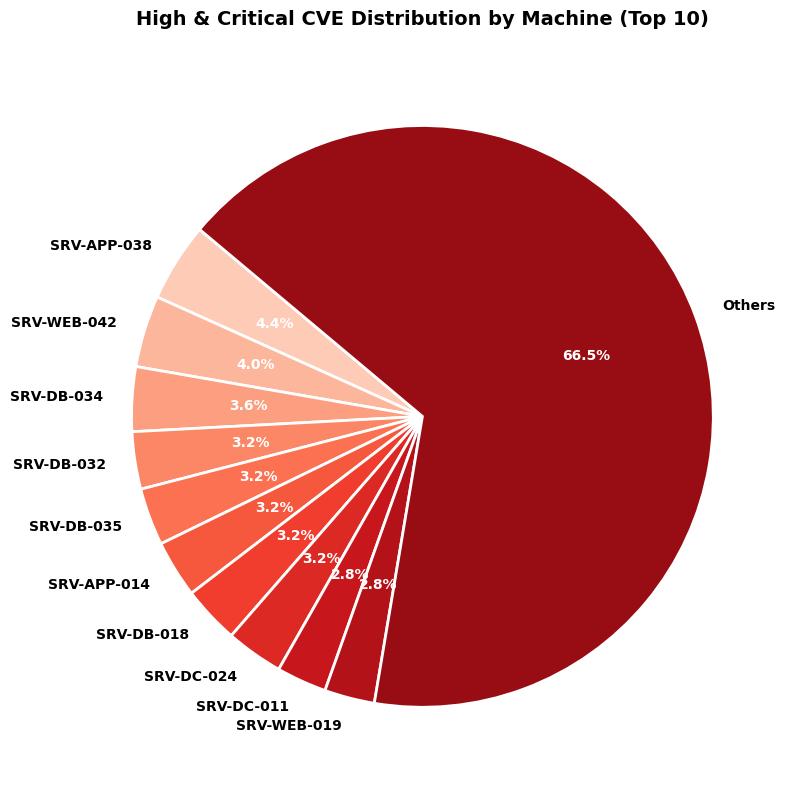


Total High/Critical CVEs: 251
Machines with High/Critical CVEs: 50


In [ ]:
# Analyze distribution of High and Critical CVEs across machines
high_critical_df = df_t.filter(F.col("Severity").isin(["High", "Critical"]))

# Count per machine
high_counts = (
    high_critical_df.groupBy("MachineName")
        .agg(F.countDistinct("VulnId").alias("HighCriticalCVEs"))
        .orderBy(F.col("HighCriticalCVEs").desc())
)

# Convert to pandas and keep top 10
high_pd = high_counts.toPandas()
top_n = 10
top_pd = high_pd.head(top_n).copy()
others_sum = high_pd["HighCriticalCVEs"][top_n:].sum()

if others_sum > 0:
    top_pd.loc[len(top_pd)] = ["Others", others_sum]

# Plot pie chart
plt.figure(figsize=(10, 8))
colors = plt.cm.Reds(range(50, 250, int(200/len(top_pd))))

wedges, texts, autotexts = plt.pie(
    top_pd["HighCriticalCVEs"],
    labels=top_pd["MachineName"],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 10, 'weight': 'bold'}
)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

plt.title("High & Critical CVE Distribution by Machine (Top 10)", 
          fontsize=14, weight="bold", pad=20)
plt.tight_layout()
plt.show()

print(f"\nTotal High/Critical CVEs: {high_pd['HighCriticalCVEs'].sum():,}")
print(f"Machines with High/Critical CVEs: {len(high_pd)}")

## 8. Exploited in Wild Analysis
Focus on actively exploited vulnerabilities requiring immediate attention

In [16]:
# Identify vulnerabilities actively exploited in the wild
exploited_vulns = (
    df_t.filter(F.col("ExploitedInWildBool") == True)
        .groupBy("VulnId", "VulnTitle", "Severity", "CvssReal")
        .agg(
            F.countDistinct("MachineName").alias("AffectedMachines"),
            F.count("*").alias("TotalInstances"),
            F.max(F.when(F.col("PatchAvailableBool"), "Yes").otherwise("No")).alias("PatchAvailable")
        )
        .orderBy(F.col("CvssReal").desc(), F.col("AffectedMachines").desc())
)

exploited_count = exploited_vulns.count()

print("\n⚠️  CRITICAL: Vulnerabilities Exploited in the Wild")
print("="*80)
print(f"Unique CVEs Exploited: {exploited_count:,}\n")

if exploited_count > 0:
    exploited_vulns.show(50, truncate=False)
    
    # Show affected machines for top exploited CVEs
    print("\n📍 Machines Affected by Exploited CVEs:")
    top_exploited = exploited_vulns.limit(5).select("VulnId").rdd.flatMap(lambda x: x).collect()
    
    for vuln_id in top_exploited:
        machines = df_t.filter(
            (F.col("VulnId") == vuln_id) & 
            (F.col("ExploitedInWildBool") == True)
        ).select("MachineName", "IPAddress", "Application").distinct()
        
        print(f"\n  {vuln_id}:")
        machines.show(10, truncate=False)
else:
    print("✓ No vulnerabilities currently exploited in the wild detected.")

StatementMeta(MSGMedium, 0, 17, Finished, Available, Finished)


⚠️  CRITICAL: Vulnerabilities Exploited in the Wild
Unique CVEs Exploited: 121

+--------------+--------------------------+--------+--------+----------------+--------------+--------------+
|VulnId        |VulnTitle                 |Severity|CvssReal|AffectedMachines|TotalInstances|PatchAvailable|
+--------------+--------------------------+--------+--------+----------------+--------------+--------------+
|CVE-2024-10213|Security Vulnerability 213|Low     |10.0    |1               |1             |No            |
|CVE-2024-10354|Security Vulnerability 354|Medium  |10.0    |1               |1             |No            |
|CVE-2024-10357|Security Vulnerability 357|Critical|9.9     |1               |1             |No            |
|CVE-2024-10492|Security Vulnerability 492|Critical|9.9     |1               |1             |No            |
|CVE-2024-10029|Security Vulnerability 29 |Medium  |9.8     |1               |1             |Yes           |
|CVE-2024-10104|Security Vulnerability 104|Low 

## 9. Specific Machine Deep Dive
Analyze vulnerabilities for a specific machine (example: BobVM)

In [17]:
# Specify the machine to analyze
TARGET_MACHINE = "BobVM"  # Change this to analyze a different machine

machine_analysis = (
    df_t.filter(F.col("MachineName") == TARGET_MACHINE)
        .groupBy("MachineName", "IPAddress")
        .agg(
            F.count("*").alias("TotalVulns"),
            F.countDistinct("VulnId").alias("UniqueCVEs"),
            F.max("CvssReal").alias("MaxCvss"),
            F.avg("CvssReal").alias("AvgCvss"),
            F.max("TimeGeneratedTs").alias("LatestScan"),
            F.sum(F.when(F.col("Severity") == "Critical", 1).otherwise(0)).alias("Critical"),
            F.sum(F.when(F.col("Severity") == "High", 1).otherwise(0)).alias("High"),
            F.sum(F.when(F.col("Severity") == "Medium", 1).otherwise(0)).alias("Medium"),
            F.sum(F.when(F.col("ExploitAvailableBool") == True, 1).otherwise(0)).alias("ExploitAvailable"),
            F.sum(F.when(F.col("ExploitedInWildBool") == True, 1).otherwise(0)).alias("ExploitedInWild"),
            F.sum(F.when(F.col("PatchAvailableBool") == True, 1).otherwise(0)).alias("Patchable")
        )
)

print(f"\n🔍 Deep Dive Analysis: {TARGET_MACHINE}")
print("="*80)
machine_analysis.show(truncate=False)

# Show top vulnerabilities for this machine
print(f"\n📋 Top Vulnerabilities on {TARGET_MACHINE}:")
top_vulns = (
    df_t.filter(F.col("MachineName") == TARGET_MACHINE)
        .select(
            "VulnId", "VulnTitle", "Severity", "CvssReal",
            "ExploitAvailableBool", "ExploitedInWildBool", "PatchAvailableBool",
            "Application"
        )
        .orderBy(F.col("CvssReal").desc())
)
top_vulns.show(20, truncate=False)

StatementMeta(MSGMedium, 0, 18, Finished, Available, Finished)


🔍 Deep Dive Analysis: BobVM
+-----------+---------+----------+----------+-------+-------+--------------------------+--------+----+------+----------------+---------------+---------+
|MachineName|IPAddress|TotalVulns|UniqueCVEs|MaxCvss|AvgCvss|LatestScan                |Critical|High|Medium|ExploitAvailable|ExploitedInWild|Patchable|
+-----------+---------+----------+----------+-------+-------+--------------------------+--------+----+------+----------------+---------------+---------+
|BobVM      |         |5         |5         |10.0   |9.62   |2026-01-20 00:55:44.983356|4       |1   |0     |3               |0              |2        |
+-----------+---------+----------+----------+-------+-------+--------------------------+--------+----+------+----------------+---------------+---------+


📋 Top Vulnerabilities on BobVM:
+---------------------+-----------------------------------------------------+--------+--------+--------------------+-------------------+------------------+-----------+
|Vul

## 10. Top 10 Most Common CVEs
Identify widespread vulnerabilities affecting multiple machines

In [18]:
# Find the most common CVEs across all machines
common_cves = (
    df_t.groupBy("VulnId", "VulnTitle", "Severity", "CvssReal")
        .agg(
            F.countDistinct("MachineName").alias("AffectedMachines"),
            F.count("*").alias("TotalInstances"),
            F.max(F.when(F.col("PatchAvailableBool"), "Yes").otherwise("No")).alias("PatchAvailable"),
            F.max(F.when(F.col("ExploitAvailableBool"), "Yes").otherwise("No")).alias("ExploitAvailable")
        )
        .orderBy(F.col("AffectedMachines").desc(), F.col("CvssReal").desc())
)

print("\n📊 Top 10 Most Widespread CVEs")
print("="*80)
common_cves.show(10, truncate=False)

StatementMeta(MSGMedium, 0, 19, Finished, Available, Finished)


📊 Top 10 Most Widespread CVEs
+--------------+---------------------------------------------+--------+--------+----------------+--------------+--------------+----------------+
|VulnId        |VulnTitle                                    |Severity|CvssReal|AffectedMachines|TotalInstances|PatchAvailable|ExploitAvailable|
+--------------+---------------------------------------------+--------+--------+----------------+--------------+--------------+----------------+
|CVE-2024-10213|Security Vulnerability 213                   |Low     |10.0    |1               |1             |No            |Yes             |
|CVE-2024-10354|Security Vulnerability 354                   |Medium  |10.0    |1               |1             |No            |Yes             |
|CVE-2024-10390|Security Vulnerability 390                   |High    |10.0    |1               |1             |Yes           |No              |
|CVE-2024-10490|Security Vulnerability 490                   |Critical|10.0    |1               |1 

## 11. Application Vulnerability Analysis
Identify which applications have the most vulnerabilities

In [19]:
# Analyze vulnerabilities by application
app_vulns = (
    df_t.groupBy("Application")
        .agg(
            F.count("*").alias("TotalVulns"),
            F.countDistinct("VulnId").alias("UniqueCVEs"),
            F.countDistinct("MachineName").alias("AffectedMachines"),
            F.max("CvssReal").alias("MaxCvss"),
            F.avg("CvssReal").alias("AvgCvss"),
            F.sum(F.when(F.col("Severity").isin(["High", "Critical"]), 1).otherwise(0)).alias("HighCritical"),
            F.sum(F.when(F.col("PatchAvailableBool"), 1).otherwise(0)).alias("Patchable")
        )
        .orderBy(F.col("HighCritical").desc(), F.col("TotalVulns").desc())
)

print("\n🎯 Vulnerability Analysis by Application")
print("="*80)
app_vulns.show(25, truncate=False)

StatementMeta(MSGMedium, 0, 20, Finished, Available, Finished)


🎯 Vulnerability Analysis by Application
+-----------+----------+----------+----------------+-------+----------------+------------+---------+
|Application|TotalVulns|UniqueCVEs|AffectedMachines|MaxCvss|AvgCvss         |HighCritical|Patchable|
+-----------+----------+----------+----------------+-------+----------------+------------+---------+
|           |505       |505       |51              |10.0   |7.02930693069307|251         |247      |
+-----------+----------+----------+----------------+-------+----------------+------------+---------+



## 12. Trend Analysis - Vulnerability Detection Over Time
Visualize when vulnerabilities were first detected

StatementMeta(MSGMedium, 0, 21, Finished, Available, Finished)

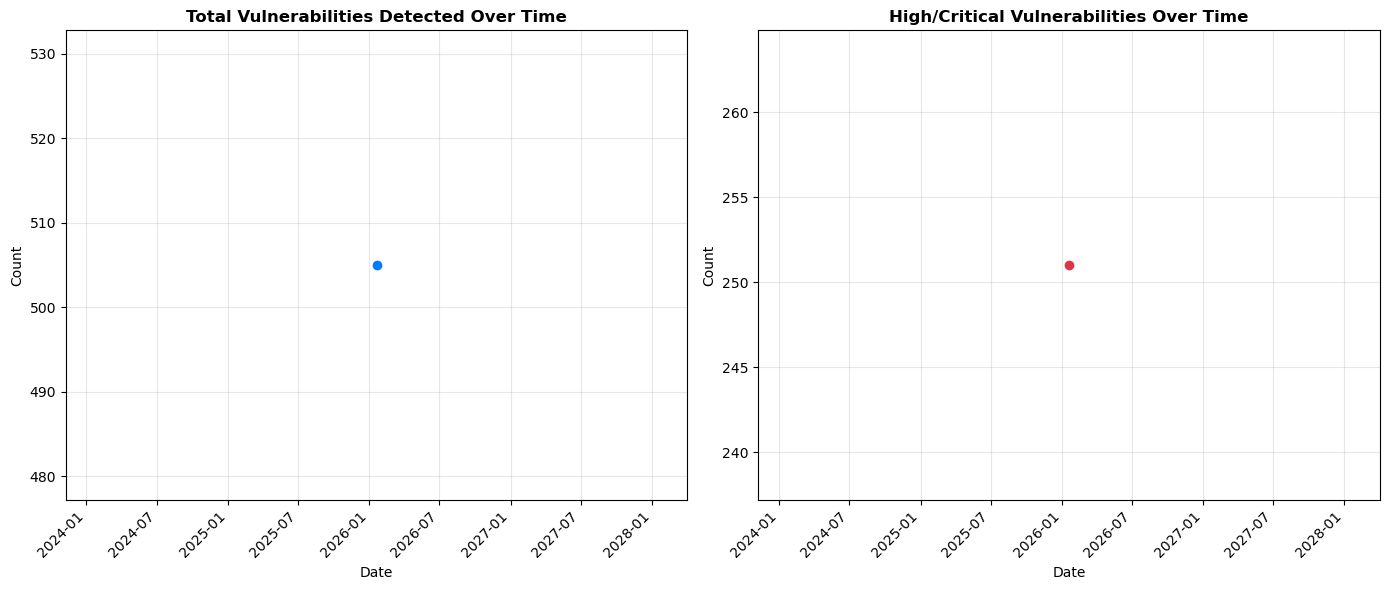

In [20]:
# Analyze vulnerability detection trends
trend_data = (
    df_t.withColumn("DetectionDate", F.to_date("TimeGeneratedTs"))
        .groupBy("DetectionDate")
        .agg(
            F.count("*").alias("Vulnerabilities"),
            F.countDistinct("VulnId").alias("UniqueCVEs"),
            F.sum(F.when(F.col("Severity").isin(["High", "Critical"]), 1).otherwise(0)).alias("HighCritical")
        )
        .orderBy("DetectionDate")
)

trend_pd = trend_data.toPandas()

if not trend_pd.empty:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(trend_pd["DetectionDate"], trend_pd["Vulnerabilities"], 
             marker='o', linewidth=2, markersize=6, color='#007bff')
    plt.title("Total Vulnerabilities Detected Over Time", fontsize=12, weight="bold")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(trend_pd["DetectionDate"], trend_pd["HighCritical"], 
             marker='o', linewidth=2, markersize=6, color='#dc3545')
    plt.title("High/Critical Vulnerabilities Over Time", fontsize=12, weight="bold")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No trend data available")

## Summary
This notebook provides comprehensive vulnerability analysis including:
- Machine risk scoring and prioritization
- Recent vulnerability detection tracking
- Quick win identification for immediate remediation
- Exploitation status monitoring
- Application and trend analysis

**Next Steps:**
1. Review machines with high risk scores
2. Prioritize patching exploited-in-wild vulnerabilities
3. Address quick wins to rapidly reduce risk
4. Schedule regular scans to maintain visibility